In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import torch
from tqdm import tqdm
import torchdiffeq
import pygot
import pandas as pd
import wot
import cospar as cs
import seaborn as sns
import pandas as pd
from pygot.external import TIGON_interface
from help_function import cell_fate_helper as hf
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
%matplotlib inline

In [3]:
import random
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
 
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True


## Preprocess 

In [4]:

adata = sc.read('../pygot_data/03_cellfate/Oren_2021_Nature.h5ad')

In [4]:
adata.layers['counts'] = adata.X.copy()

In [5]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [6]:
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='cell_ranger')

In [7]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

In [8]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

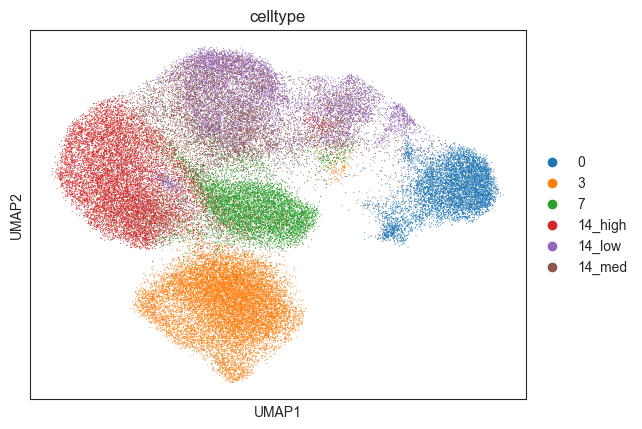

In [9]:
sc.pl.umap(adata, color='celltype')

<Axes: >

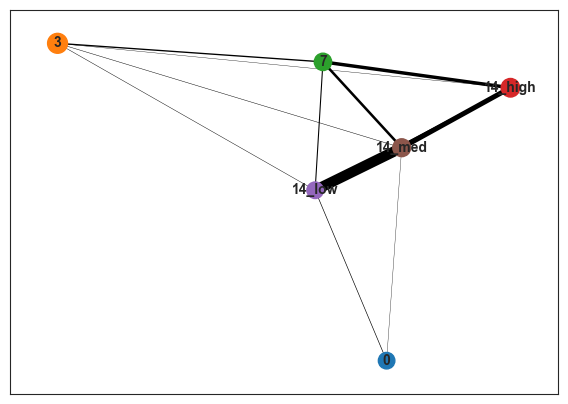

In [10]:
sc.tl.paga(adata, groups="celltype")
sc.pl.paga(adata, threshold=0.03, show=False)

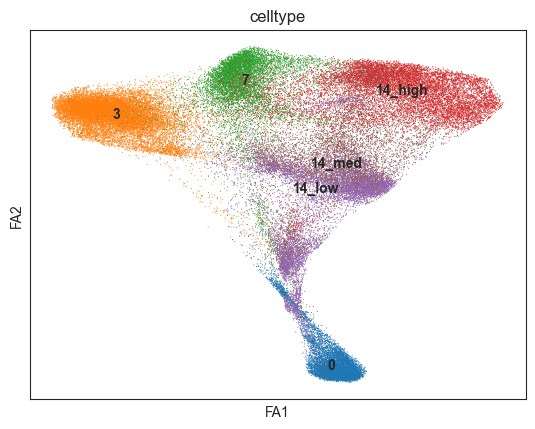

In [13]:
sc.tl.draw_graph(adata, init_pos="paga")
sc.pl.draw_graph(
    adata, color=["celltype"], legend_loc="on data"
)

In [ ]:
from scipy.sparse import csr_matrix
import numpy as np
clone_key = 'lineage_barcode'
adata.obs[clone_key] = adata.obs[clone_key].astype(str)
#clone_library = adata.obs[clone_key][~np.isnan(adata.obs[clone_key])].unique()
clone_library = adata.obs[clone_key][adata.obs[clone_key] != 'nan'].unique()
X_clone = np.zeros(shape=(len(adata), len(clone_library)))
for i in range(len(clone_library)):
    X_clone[np.where(adata.obs[clone_key] == clone_library[i])[0], i] = 1
X_clone = csr_matrix(X_clone)
adata.obsm['X_clone'] = X_clone

In [ ]:
adata.obs['stage_numeric'] = adata.obs['time_point'].replace(dict(zip(np.sort(np.unique(adata.obs['time_point'])), range(len(adata.obs['time_point'].unique())))))
adata.obs['time_info'] = adata.obs['stage_numeric']
adata.obs['state_info'] = adata.obs['celltype']
adata.obsm['X_emb'] = adata.obsm['X_umap']
sc.write('../pygot_data/03_cellfate/Oren/adata.h5ad', adata)

In [93]:
adata

AnnData object with n_obs × n_vars = 56419 × 3000
    obs: 'nCount_RNA', 'nFeature_RNA', 'nGene', 'nUMI', 'percent.mito', 'sample_id', 'time_point', 'sample_name', 'sample_type', 'full_cell_barcode', 'lineage_barcode', 'clone_size', 'nCount_SCT', 'nFeature_SCT', 'celltype', 'barcodes', 'barcode1', 'barcodes_multi', 'stage_numeric', 'time_info', 'state_info', 'pull', 'pull_high', 'pull_low', 'moscot_fate_bias', 'transition', 'idx', 'got_fate_bias'
    var: 'name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'celltype_sizes', 'clonal_time_points', 'data_des', 'draw_graph', 'hvg', 'log1p', 'moscot_results', 'neighbors', 'paga', 'pca', 'state_info_colors', 'time_ordering', 'umap'
    obsm: 'X_clone', 'X_draw_graph_fa', 'X_emb', 'X_pca', 'X_umap', 'velocity_pca', 'descendant', 'ancestor'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [98]:
adata.obs['cell_state'] = 'Others'
adata.obs.loc[adata.obs.celltype == '14_low', 'cell_state'] = 'Cycling'
adata.obs.loc[adata.obs.celltype == '14_high', 'cell_state'] = 'Non-cycling'
adata.obs.loc[adata.obs.celltype == '14_med', 'cell_state'] = 'Moderate'

In [118]:
adata.uns['cell_state_colors'] = ['#ffe2d3', '#fa9471', '#dc2e22', '#d1d3d5'    ]

In [125]:
adata.obs[time_key] = adata.obs[time_key].astype(int)
fig, axes = plt.subplots(1,2, figsize=(6.4*2, 4.8))
sc.pl.embedding(adata, color=[time_key], basis='draw_graph_fa', ax=axes[0], colorbar_loc=None, frameon=False, show=False, title=[''], legend_loc=None, s=5)
sc.pl.embedding(adata, color=['cell_state'], basis='draw_graph_fa', ax=axes[1], colorbar_loc=None, frameon=False, show=False, title=[''], legend_loc=None, s=5)



## Compute Grond Truth based on Clone Information

In [3]:
adata = sc.read('/storage/xuruihong/repository/pygot_data/03_cellfate/Oren/adata.h5ad')

Infer transition map between neighboring time points.
--> Clonal cell fraction (day 0-1): 0.5151962230746533
--> Clonal cell fraction (day 1-2): 0.39029653348183213
--> Clonal cell fraction (day 2-3): 0.387929993964997
--> Clonal cell fraction (day 1-0): 0.44549631073367674
--> Clonal cell fraction (day 2-1): 0.3526855763427882
--> Clonal cell fraction (day 3-2): 0.3175620600222305
--> Numer of cells that are clonally related -- day 0: 3492  and day 1: 6400
--> Numer of cells that are clonally related -- day 1: 5607  and day 2: 2922
--> Numer of cells that are clonally related -- day 2: 3214  and day 3: 8571
Number of multi-time clones post selection: 2653
Cell number=56419, Clone number=2653
--> clonal_cell_id_t1: 12313
--> Tmap_cell_id_t1: 29429
Use all clones (naive method)
Use all clones (naive method)
Use all clones (naive method)


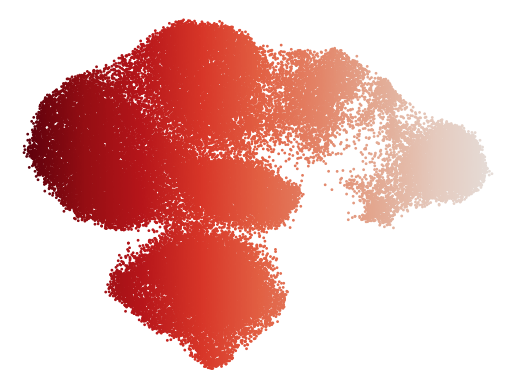

In [4]:

adata_processed = cs.tmap.infer_Tmap_from_clonal_info_alone(
    adata,
)

In [5]:
cs.tl.fate_map(
    adata_processed,
    selected_fates=['14_high', '14_low'],
    source="clonal_transition_map",
    map_backward=True,
)


Results saved at adata.obs['fate_map_clonal_transition_map_14_high']
Results saved at adata.obs['fate_map_clonal_transition_map_14_low']


In [6]:
x0_adata = adata_processed[adata_processed.obs['sample_type'].isin(['0', '3', '7'])] 
x0_adata = x0_adata[(x0_adata.obs['fate_map_clonal_transition_map_14_high'] + x0_adata.obs['fate_map_clonal_transition_map_14_low']) > 0.]

In [7]:
factor = x0_adata.obs[['fate_map_clonal_transition_map_14_high', 'fate_map_clonal_transition_map_14_low']].sum(axis=1)
x0_adata.obs['fate_map_clonal_transition_map_14_high'] /= factor
x0_adata.obs['fate_map_clonal_transition_map_14_low'] /= factor


In [8]:
x0_adata.obs['ground_truth'] = x0_adata.obs['fate_map_clonal_transition_map_14_low']

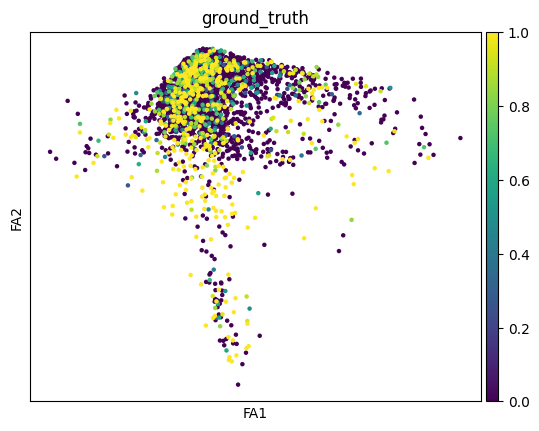

In [9]:
sc.pl.draw_graph(x0_adata, color=['ground_truth'])

In [10]:
groundtruth_key = 'ground_truth'

## Train Model

In [11]:
embedding_key = 'X_pca'
velocity_key = 'velocity_pca'
time_key = 'stage_numeric'
cell_type_key = 'celltype'

### GOT

In [136]:
gots = []
for i in range(10):
    model, _ = pygot.tl.traj.fit_velocity_model(adata, embedding_key=embedding_key, x_centric_iter_n=5000, time_key=time_key, path='../pygot_data/03_cellfate/Oren/')
    gots.append(model)

loading saved shortest path profile


loss :92.5663  best :92.5045: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:54<00:00, 21.32it/s]


loading saved shortest path profile


loss :92.3588  best :92.2693: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:49<00:00, 21.76it/s]


loading saved shortest path profile


loss :92.0468  best :91.7507: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:48<00:00, 21.93it/s]


loading saved shortest path profile


loss :91.7584  best :91.7584: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:47<00:00, 21.97it/s]


loading saved shortest path profile


loss :92.3102  best :92.1988: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:52<00:00, 21.47it/s]


loading saved shortest path profile


loss :92.2082  best :92.0482: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:49<00:00, 21.74it/s]


loading saved shortest path profile


loss :92.0716  best :92.0523: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:52<00:00, 21.52it/s]


loading saved shortest path profile


loss :92.3314  best :92.0634: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:52<00:00, 21.51it/s]


loading saved shortest path profile


loss :91.8642  best :91.8346: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:49<00:00, 21.79it/s]


loading saved shortest path profile


loss :92.8699  best :92.6329: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:49<00:00, 21.76it/s]


In [141]:
for i, got in enumerate(gots):
    os.system('mkdir ./benchmark_model/GOT/03_cell_fate/oren/pc50/'+str(i))
    torch.save(got, './benchmark_model/GOT/03_cell_fate/oren/pc50/'+str(i)+'/model.pkl')

mkdir: cannot create directory ‘./benchmark_model/GOT/03_cell_fate/oren/pc50/0’: File exists


In [12]:
gots = []
for i in range(10):
    gots.append(torch.load('./benchmark_model/GOT/03_cell_fate/oren/pc50/'+str(i)+'/model.pkl', map_location='cpu'))

### Moscot

In [ ]:
# run with [benchmark]03_cell_fate_cancer_run_moscot.py

In [28]:

moscot_dfs = []
for e in [1e-1, 5e-1, 1e-2, 5e-2, 1e-3, 5e-3, 1e-4]:
    moscot_dfs.append(pd.read_csv('../pygot_data/03_cellfate/Oren/moscot_v4.0_{}.csv'.format(e), index_col=0))

    

### WOT

In [29]:
import wot
for e in [1e-1, 5e-1, 1e-2, 5e-2, 2e-2, 3e-2, 5e-3]:
    ot_model = wot.ot.OTModel(adata, epsilon = e, lambda1 = 50, lambda2 = 1, growth_iters = 1, day_field=time_key,) 
    ot_model.compute_all_transport_maps('../pygot_data/03_cellfate/Oren/serum_{}'.format(e))

2025-02-25 14:47:42,038 - INFO - Computing transport map from 0 to 1
2025-02-25 14:54:55,834 - INFO - Computing transport map from 1 to 2
2025-02-25 15:01:37,322 - INFO - Computing transport map from 2 to 3
2025-02-25 15:16:55,773 - INFO - Computing transport map from 0 to 1
2025-02-25 15:20:22,590 - INFO - Computing transport map from 1 to 2
2025-02-25 15:26:12,961 - INFO - Computing transport map from 2 to 3
2025-02-25 15:40:38,589 - INFO - Computing transport map from 0 to 1
2025-02-25 16:06:29,276 - INFO - Computing transport map from 1 to 2
2025-02-25 16:34:10,106 - INFO - Computing transport map from 2 to 3


In [21]:

def get_wot_fate(tmap_model):
    t023 = tmap_model.get_coupling(t0=0, t1=3, covariate=None)
    t123 = tmap_model.get_coupling(t0=1, t1=3, covariate=None)
    t223 = tmap_model.get_coupling(t0=2, t1=3, covariate=None)
    
    def calcu_fate(chain, start_index):
        
        P0 = chain @ (adata.obs[adata.obs[time_key]==3][cell_type_key] == '14_low').astype(int).to_numpy()
        P1 = chain @ (adata.obs[adata.obs[time_key]==3][cell_type_key] == '14_high').astype(int).to_numpy()
        
        
        return pd.DataFrame([P0, P1], columns=start_index, index=['14_low','14_high']).T
    
    
    fate1 = calcu_fate(t023.X, t023.obs.index)
    fate2 = calcu_fate(t123.X, t123.obs.index)
    fate3 = calcu_fate(t223.X, t223.obs.index)
    return pd.concat([fate1, fate2, fate3])

In [22]:
wot_dfs = []
for e in [1e-1, 5e-1, 1e-2, 5e-2, 2e-2, 3e-2, 5e-3]:
    print(e)
    wot_dfs.append(get_wot_fate(wot.tmap.TransportMapModel.from_directory('../pygot_data/03_cellfate/Oren/serum_{}'.format(e))))

0.1
0.5
0.01
0.05
0.02
0.03
0.005


### Cospar

In [49]:
def generate_clone_matrix(adata, clone_key):
    
    all_clone = adata.obs[clone_key][adata.obs[clone_key] == adata.obs[clone_key]].unique()
    
    X_clone = np.zeros((len(adata), len(all_clone)))
    adata.obs['idx'] = range(len(adata))
    for i, clone in enumerate(all_clone):
        j = adata.obs.loc[adata.obs[clone_key] == clone]['idx'].tolist()
        X_clone[j, i] = 1
    adata.obsm['X_clone'] = X_clone

(56419, 10269)
(56419, 5134)
Time points with clonal info: [0 1 2 3]
------Compute the full Similarity matrix if necessary------
--> Compute similarity matrix: computing new; beta=0.1
Smooth round: 1
--> Time elapsed: 0.7012672424316406
Smooth round: 2
--> Time elapsed: 1.4806346893310547
Smooth round: 3
--> Time elapsed: 22.444058656692505
--> Orignal sparsity=0.10522440271933081, Thresholding
--> Final sparsity=0.052967936722433266
similarity matrix truncated (Smooth round=3):  28.697667837142944
Smooth round: 4
--> Time elapsed: 39.732022523880005
--> Orignal sparsity=0.21946558244574815, Thresholding
--> Final sparsity=0.1034086474700155
similarity matrix truncated (Smooth round=4):  26.579482078552246
Smooth round: 5
--> Time elapsed: 62.493370056152344
--> Orignal sparsity=0.30392549424187587, Thresholding
--> Final sparsity=0.15657171544975693
similarity matrix truncated (Smooth round=5):  27.773173570632935
--> Save the matrix at every 5 rounds
Smooth round: 6
--> Time elapsed:

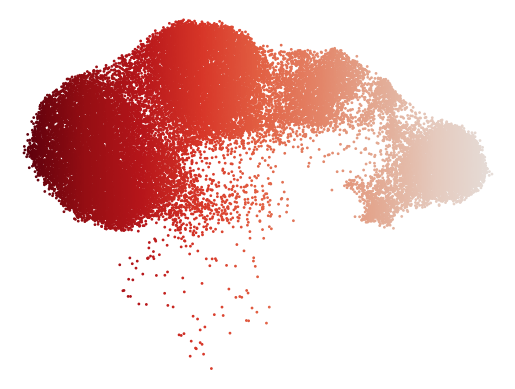

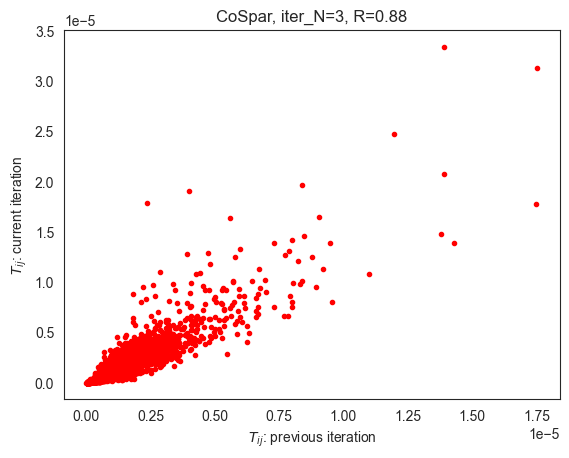

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  4.754090785980225
--> Phase II: time elapsed --  5.433546304702759
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--------Current initial time point: 1--------
Step 1: Select time points
--> Clonal cell fraction (day 1-3): 0.4708339134066546
--> Clonal cell fraction (day 3-1): 0.6587995553908855
--> Numer of cells that are clonally related -- day 1: 6764  and day 3: 17781
Number of multi-time clones post selection: 1116
Cell number=41356, Clone number=1116
--> clonal_cell_id_t1: 6764
--> Tmap_cell_id_t1: 14366
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
--> Load from hard disk--------
--> Compute similarity matrix: load existing data
--> Time elapsed:  0.7509350776672363
--> Time elapsed:  5.841870546340942
--> Time elapsed:  1.5679128170013428
--> Time elapse

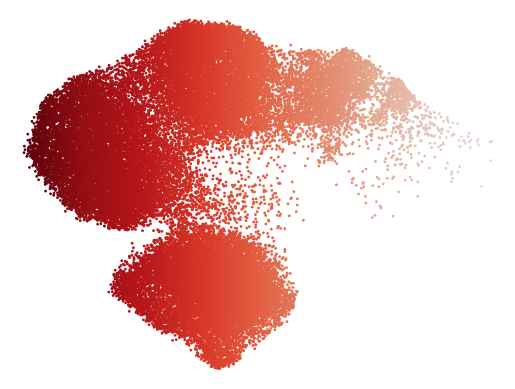

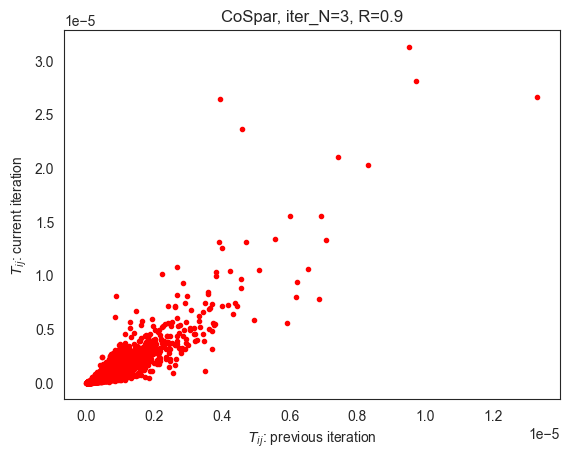

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  6.600688457489014
--> Phase II: time elapsed --  8.894113779067993
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--> Clone id: 1000
--------Current initial time point: 2--------
Step 1: Select time points
--> Clonal cell fraction (day 2-3): 0.6362100181050091
--> Clonal cell fraction (day 3-2): 0.6328269729529455
--> Numer of cells that are clonally related -- day 2: 5271  and day 3: 17080
Number of multi-time clones post selection: 780
Cell number=35275, Clone number=780
--> clonal_cell_id_t1: 5271
--> Tmap_cell_id_t1: 8285
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
--> Load from hard disk--------
--> Compute similarity matrix: load existing data
--> Time elapsed:  0.5873885154724121
--> Time elapsed:  5.2687225341796875
--> Time elapsed:  0.810337305068969

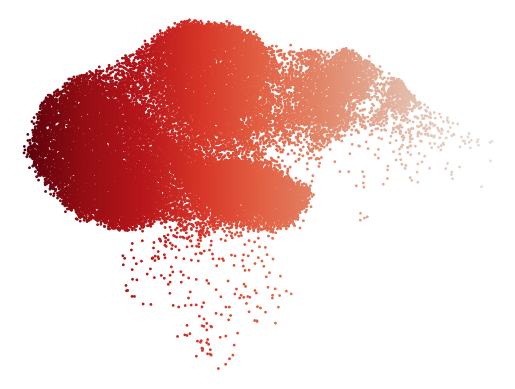

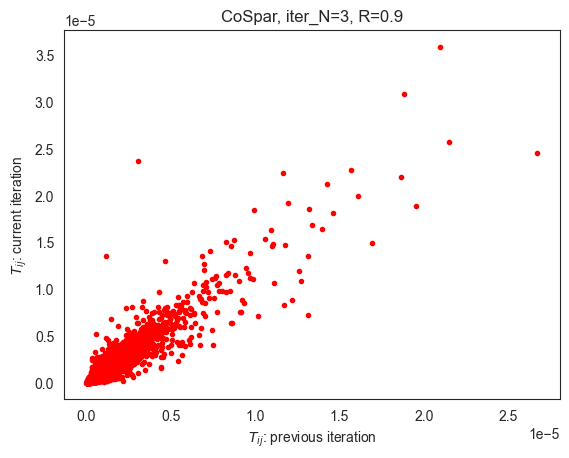

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  9.005529403686523
--> Phase II: time elapsed --  10.045884847640991
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
-----------Total used time: 7103.280570983887 s ------------
Results saved at adata.obs['fate_map_transition_map_14_low']
Results saved at adata.obs['fate_map_transition_map_14_high']
Results saved at adata.obs['fate_bias_transition_map_14_low*14_high']
(56419, 10269)
(56419, 5134)
Time points with clonal info: [0 1 2 3]
------Compute the full Similarity matrix if necessary------
--> Compute similarity matrix: computing new; beta=0.1
Smooth round: 1
--> Time elapsed: 0.9155476093292236
Smooth round: 2
--> Time elapsed: 1.5797803401947021
Smooth round: 3
--> Time elapsed: 15.215369939804077
--> Orignal sparsity=0.10522440271933081, Thresholding
--> Final sparsity=0.052967936722433266
sim

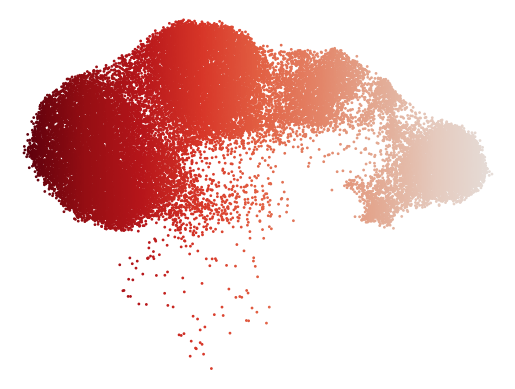

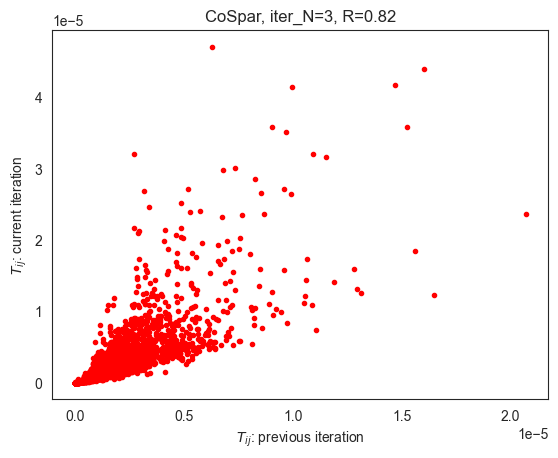

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.48723268508911133
--> Phase II: time elapsed --  0.8695154190063477
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--------Current initial time point: 1--------
Step 1: Select time points
--> Clonal cell fraction (day 1-3): 0.26841152721704026
--> Clonal cell fraction (day 3-1): 0.1949610967024824
--> Numer of cells that are clonally related -- day 1: 3856  and day 3: 5262
Number of multi-time clones post selection: 1116
Cell number=41356, Clone number=1116
--> clonal_cell_id_t1: 3856
--> Tmap_cell_id_t1: 14366
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
--> Load from hard disk--------
--> Compute similarity matrix: load existing data
--> Time elapsed:  0.530362606048584
--> Time elapsed:  3.3916525840759277
--> Time elapsed:  1.5466043949127197
--> Time ela

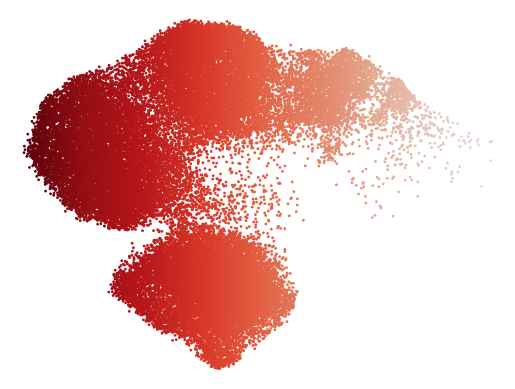

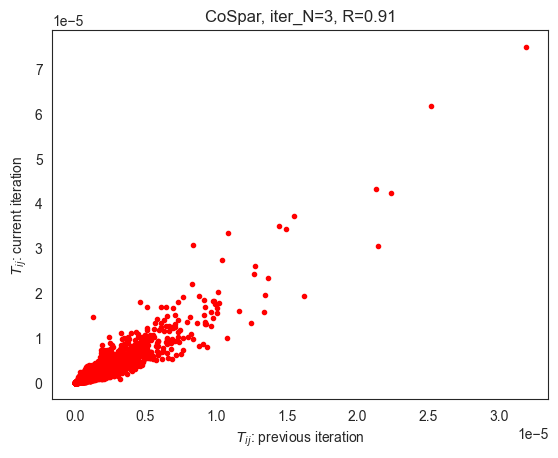

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.8566107749938965
--> Phase II: time elapsed --  2.4609949588775635
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--> Clone id: 1000
--------Current initial time point: 2--------
Step 1: Select time points
--> Clonal cell fraction (day 2-3): 0.19577549788774895
--> Clonal cell fraction (day 3-2): 0.1677658391997036
--> Numer of cells that are clonally related -- day 2: 1622  and day 3: 4528
Number of multi-time clones post selection: 771
Cell number=35275, Clone number=771
--> clonal_cell_id_t1: 1622
--> Tmap_cell_id_t1: 8285
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
--> Load from hard disk--------
--> Compute similarity matrix: load existing data
--> Time elapsed:  0.1265239715576172
--> Time elapsed:  2.115870475769043
--> Time elapsed:  0.58418059349060

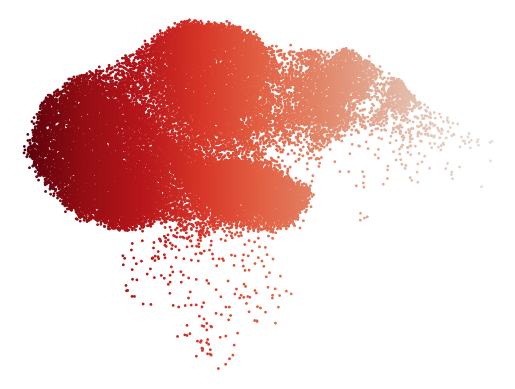

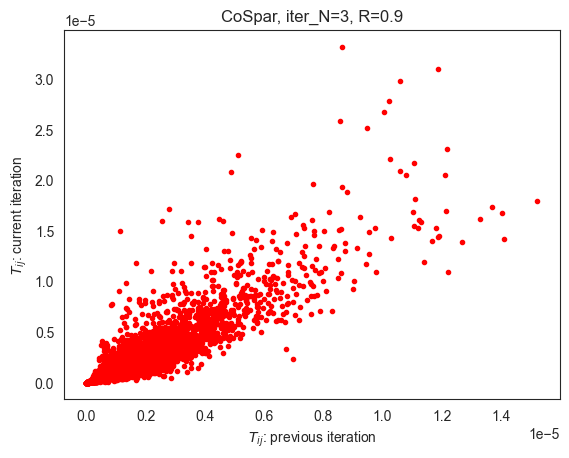

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.5598547458648682
--> Phase II: time elapsed --  1.0163676738739014
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
-----------Total used time: 7424.569334745407 s ------------
Results saved at adata.obs['fate_map_transition_map_14_low']
Results saved at adata.obs['fate_map_transition_map_14_high']
Results saved at adata.obs['fate_bias_transition_map_14_low*14_high']
(56419, 10269)
(56419, 5134)
Time points with clonal info: [0 1 2 3]
------Compute the full Similarity matrix if necessary------
--> Compute similarity matrix: computing new; beta=0.1
Smooth round: 1
--> Time elapsed: 0.9286019802093506
Smooth round: 2
--> Time elapsed: 1.591911792755127
Smooth round: 3
--> Time elapsed: 15.444930076599121
--> Orignal sparsity=0.10522440271933081, Thresholding
--> Final sparsity=0.052967936722433266
sim

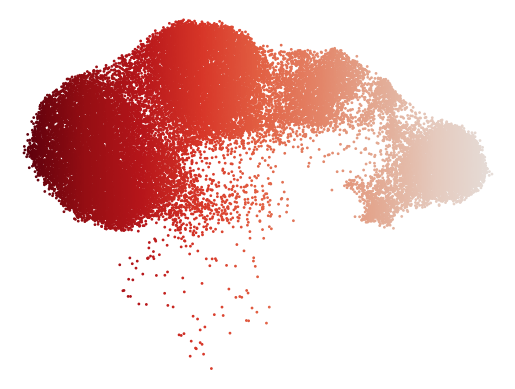

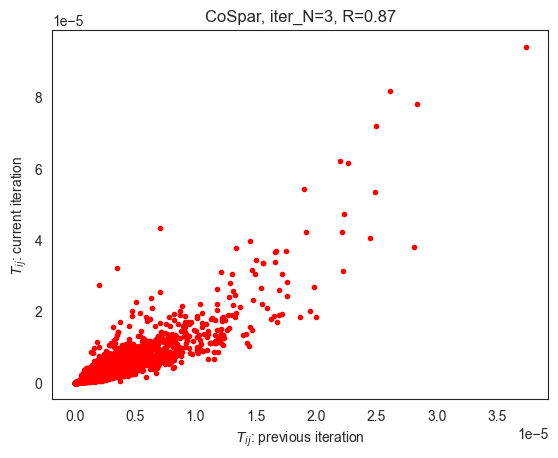

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.46099042892456055
--> Phase II: time elapsed --  0.8092150688171387
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--------Current initial time point: 1--------
Step 1: Select time points
--> Clonal cell fraction (day 1-3): 0.259153557009606
--> Clonal cell fraction (day 3-1): 0.19733234531307892
--> Numer of cells that are clonally related -- day 1: 3723  and day 3: 5326
Number of multi-time clones post selection: 1109
Cell number=41356, Clone number=1109
--> clonal_cell_id_t1: 3723
--> Tmap_cell_id_t1: 14366
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
--> Load from hard disk--------
--> Compute similarity matrix: load existing data
--> Time elapsed:  0.3554496765136719
--> Time elapsed:  2.8869283199310303
--> Time elapsed:  1.294410228729248
--> Time elap

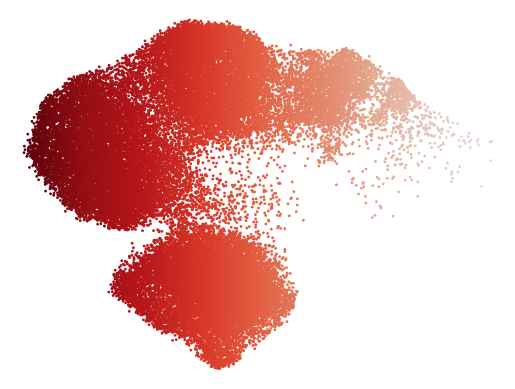

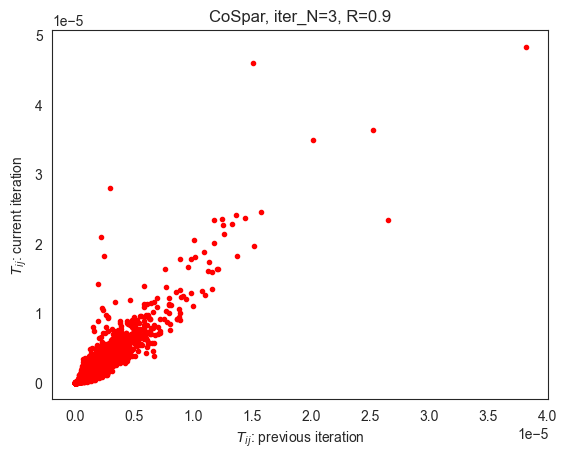

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.6619071960449219
--> Phase II: time elapsed --  2.0276412963867188
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--> Clone id: 1000
--------Current initial time point: 2--------
Step 1: Select time points
--> Clonal cell fraction (day 2-3): 0.19806879903439953
--> Clonal cell fraction (day 3-2): 0.1759540570581697
--> Numer of cells that are clonally related -- day 2: 1641  and day 3: 4749
Number of multi-time clones post selection: 785
Cell number=35275, Clone number=785
--> clonal_cell_id_t1: 1641
--> Tmap_cell_id_t1: 8285
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
--> Load from hard disk--------
--> Compute similarity matrix: load existing data
--> Time elapsed:  0.1321256160736084
--> Time elapsed:  2.3320186138153076
--> Time elapsed:  0.6044056415557

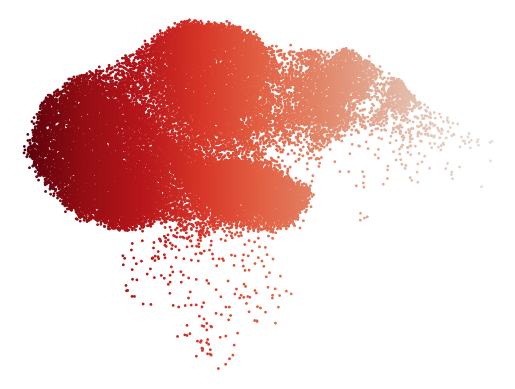

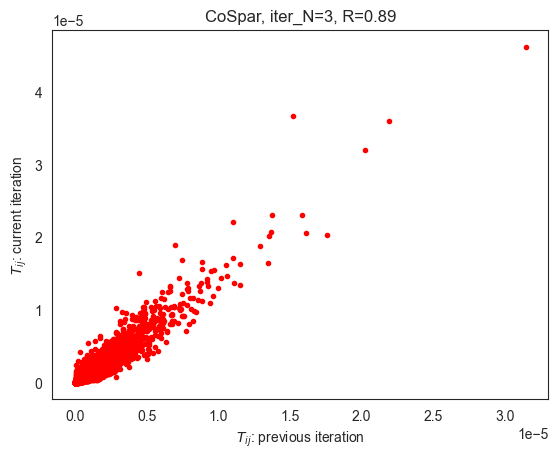

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.7171440124511719
--> Phase II: time elapsed --  1.1664397716522217
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
-----------Total used time: 6601.048217058182 s ------------
Results saved at adata.obs['fate_map_transition_map_14_low']
Results saved at adata.obs['fate_map_transition_map_14_high']
Results saved at adata.obs['fate_bias_transition_map_14_low*14_high']
(56419, 10269)
(56419, 5134)
Time points with clonal info: [0 1 2 3]
------Compute the full Similarity matrix if necessary------
--> Compute similarity matrix: computing new; beta=0.1
Smooth round: 1
--> Time elapsed: 0.7138786315917969
Smooth round: 2
--> Time elapsed: 1.3873279094696045
Smooth round: 3
--> Time elapsed: 15.08845567703247
--> Orignal sparsity=0.10522440271933081, Thresholding
--> Final sparsity=0.052967936722433266
sim

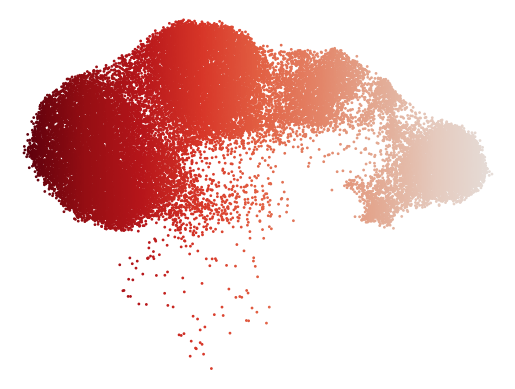

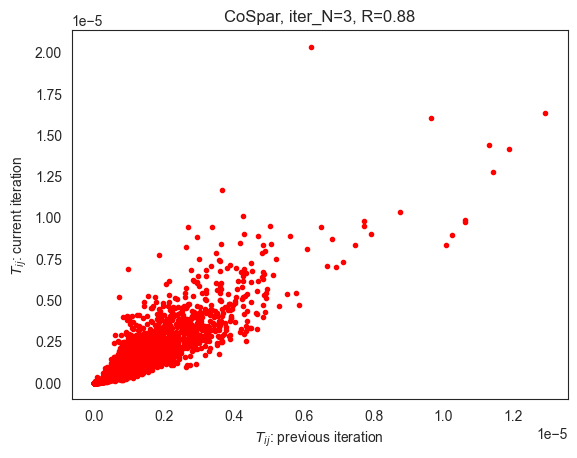

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  4.093820095062256
--> Phase II: time elapsed --  4.691085577011108
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--------Current initial time point: 1--------
Step 1: Select time points
--> Clonal cell fraction (day 1-3): 0.4626896839760546
--> Clonal cell fraction (day 3-1): 0.6427565765098184
--> Numer of cells that are clonally related -- day 1: 6647  and day 3: 17348
Number of multi-time clones post selection: 1106
Cell number=41356, Clone number=1106
--> clonal_cell_id_t1: 6647
--> Tmap_cell_id_t1: 14366
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
--> Load from hard disk--------
--> Compute similarity matrix: load existing data
--> Time elapsed:  0.7087576389312744
--> Time elapsed:  5.812790632247925
--> Time elapsed:  1.5227906703948975
--> Time elapse

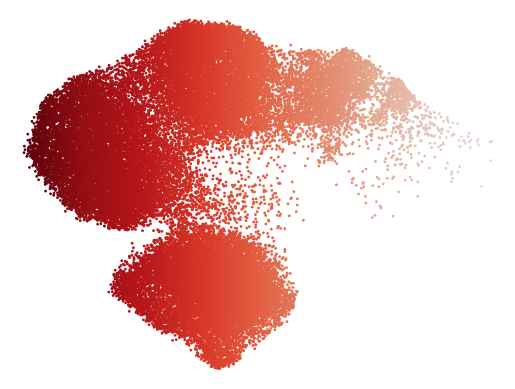

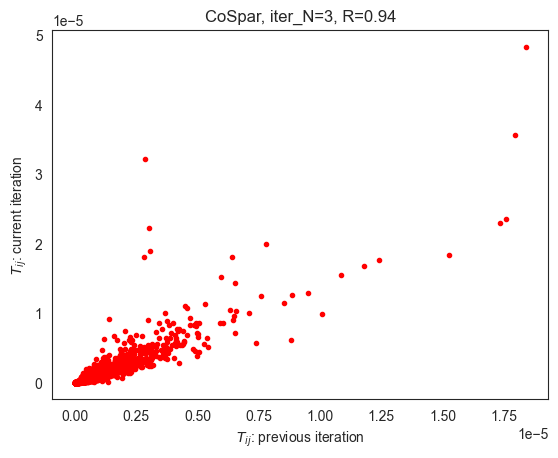

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  6.031988620758057
--> Phase II: time elapsed --  8.174151182174683
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--> Clone id: 1000
--------Current initial time point: 2--------
Step 1: Select time points
--> Clonal cell fraction (day 2-3): 0.6333132166566083
--> Clonal cell fraction (day 3-2): 0.6213041867358281
--> Numer of cells that are clonally related -- day 2: 5247  and day 3: 16769
Number of multi-time clones post selection: 774
Cell number=35275, Clone number=774
--> clonal_cell_id_t1: 5247
--> Tmap_cell_id_t1: 8285
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
--> Load from hard disk--------
--> Compute similarity matrix: load existing data
--> Time elapsed:  0.5367069244384766
--> Time elapsed:  5.04889988899231
--> Time elapsed:  0.8083312511444092


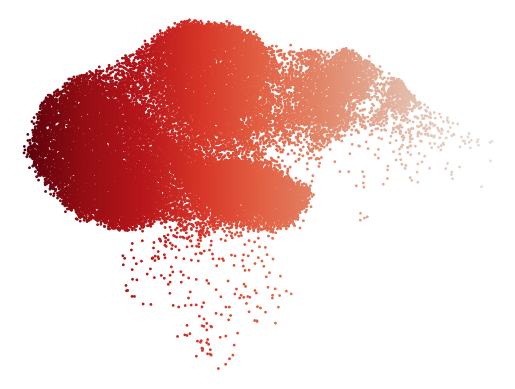

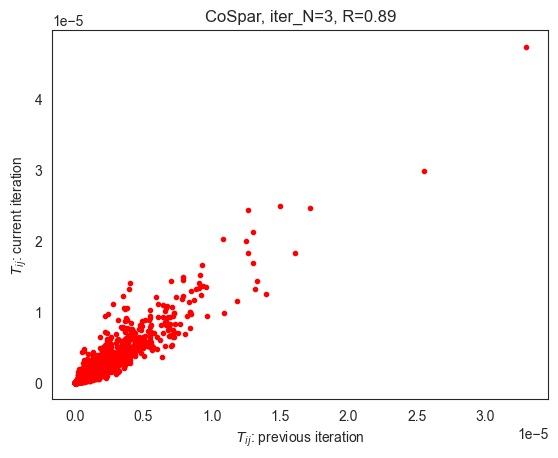

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  8.99723744392395
--> Phase II: time elapsed --  10.016260147094727
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
-----------Total used time: 7375.83954668045 s ------------
Results saved at adata.obs['fate_map_transition_map_14_low']
Results saved at adata.obs['fate_map_transition_map_14_high']
Results saved at adata.obs['fate_bias_transition_map_14_low*14_high']
(56419, 10269)
(56419, 5134)
Time points with clonal info: [0 1 2 3]
------Compute the full Similarity matrix if necessary------
--> Compute similarity matrix: computing new; beta=0.1
Smooth round: 1
--> Time elapsed: 0.7205314636230469
Smooth round: 2
--> Time elapsed: 1.3491737842559814
Smooth round: 3
--> Time elapsed: 15.193845987319946
--> Orignal sparsity=0.10522440271933081, Thresholding
--> Final sparsity=0.052967936722433266
simil

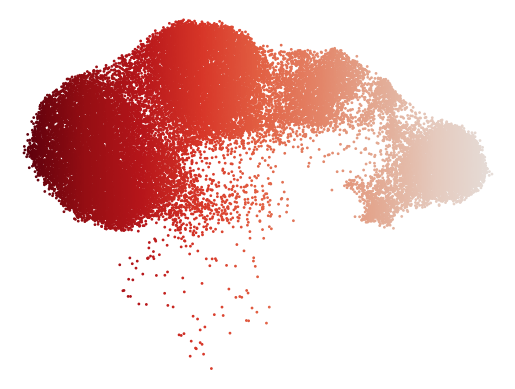

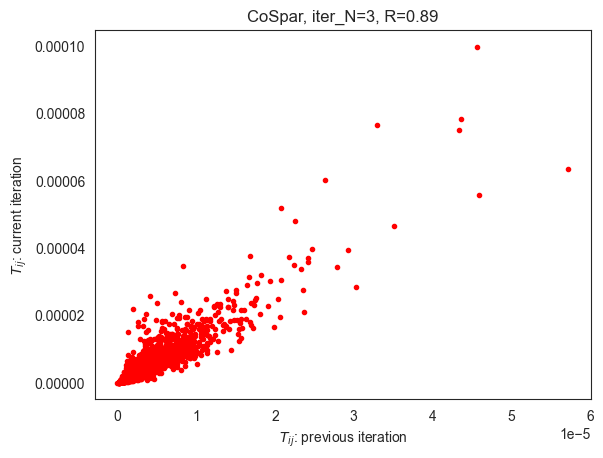

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.43206024169921875
--> Phase II: time elapsed --  0.7924139499664307
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--------Current initial time point: 1--------
Step 1: Select time points
--> Clonal cell fraction (day 1-3): 0.2617986913545872
--> Clonal cell fraction (day 3-1): 0.18810670618747685
--> Numer of cells that are clonally related -- day 1: 3761  and day 3: 5077
Number of multi-time clones post selection: 1094
Cell number=41356, Clone number=1094
--> clonal_cell_id_t1: 3761
--> Tmap_cell_id_t1: 14366
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
--> Load from hard disk--------
--> Compute similarity matrix: load existing data
--> Time elapsed:  0.36461901664733887
--> Time elapsed:  2.837383270263672
--> Time elapsed:  1.2943572998046875
--> Time el

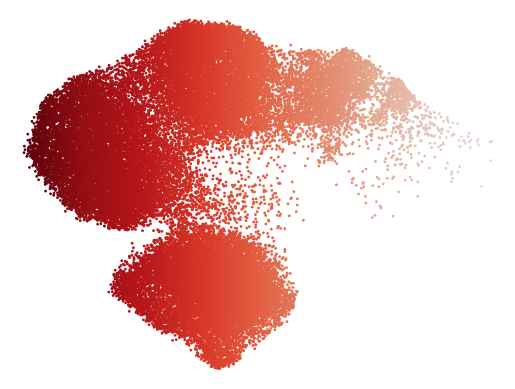

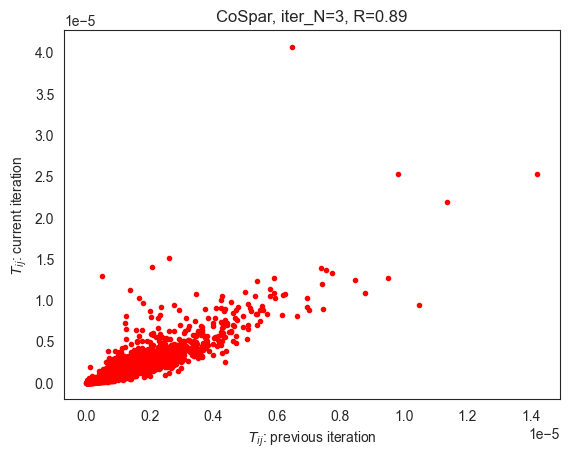

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.6410138607025146
--> Phase II: time elapsed --  2.0499675273895264
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--> Clone id: 1000
--------Current initial time point: 2--------
Step 1: Select time points
--> Clonal cell fraction (day 2-3): 0.19565479782739892
--> Clonal cell fraction (day 3-2): 0.16361615413115968
--> Numer of cells that are clonally related -- day 2: 1621  and day 3: 4416
Number of multi-time clones post selection: 803
Cell number=35275, Clone number=803
--> clonal_cell_id_t1: 1621
--> Tmap_cell_id_t1: 8285
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
--> Load from hard disk--------
--> Compute similarity matrix: load existing data
--> Time elapsed:  0.11706233024597168
--> Time elapsed:  2.142056465148926
--> Time elapsed:  0.571832180023

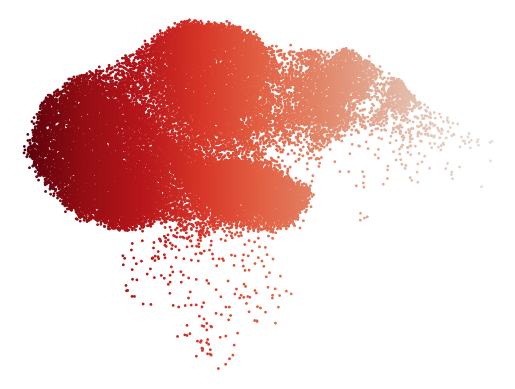

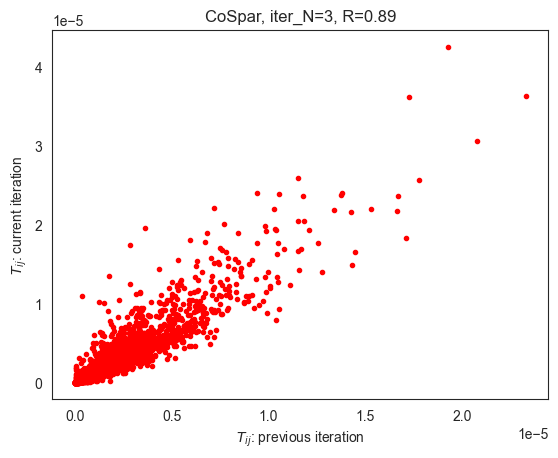

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.536186695098877
--> Phase II: time elapsed --  0.9830284118652344
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
-----------Total used time: 6296.230211257935 s ------------
Results saved at adata.obs['fate_map_transition_map_14_low']
Results saved at adata.obs['fate_map_transition_map_14_high']
Results saved at adata.obs['fate_bias_transition_map_14_low*14_high']
(56419, 10269)
(56419, 5134)
Time points with clonal info: [0 1 2 3]
------Compute the full Similarity matrix if necessary------
--> Compute similarity matrix: computing new; beta=0.1
Smooth round: 1
--> Time elapsed: 0.7151007652282715
Smooth round: 2
--> Time elapsed: 1.3551373481750488
Smooth round: 3
--> Time elapsed: 15.23287844657898
--> Orignal sparsity=0.10522440271933081, Thresholding
--> Final sparsity=0.052967936722433266
simi

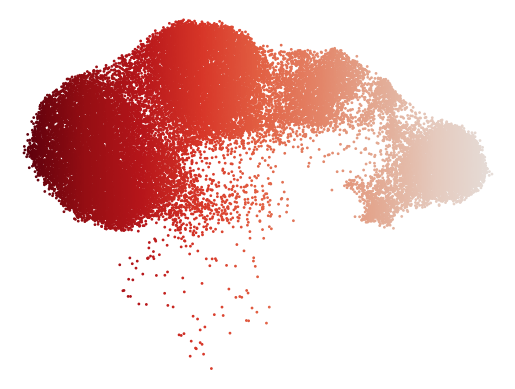

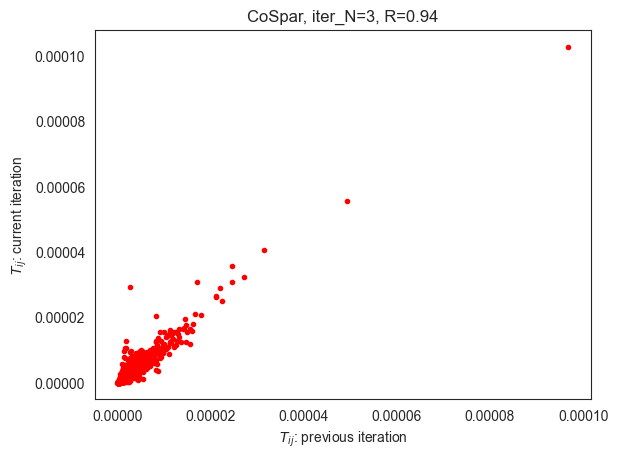

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  4.32271146774292
--> Phase II: time elapsed --  4.904498338699341
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--------Current initial time point: 1--------
Step 1: Select time points
--> Clonal cell fraction (day 1-3): 0.46832799665877767
--> Clonal cell fraction (day 3-1): 0.6369766580214894
--> Numer of cells that are clonally related -- day 1: 6728  and day 3: 17192
Number of multi-time clones post selection: 1111
Cell number=41356, Clone number=1111
--> clonal_cell_id_t1: 6728
--> Tmap_cell_id_t1: 14366
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
--> Load from hard disk--------
--> Compute similarity matrix: load existing data
--> Time elapsed:  0.7233304977416992
--> Time elapsed:  5.92949366569519
--> Time elapsed:  1.5492348670959473
--> Time elapsed

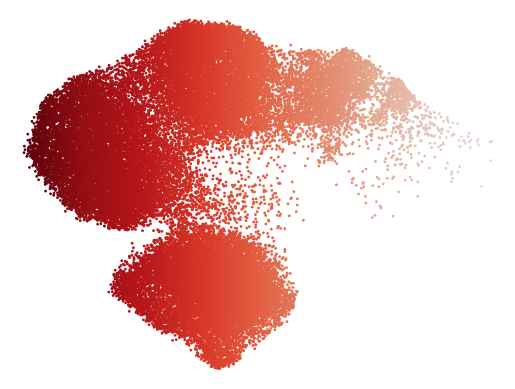

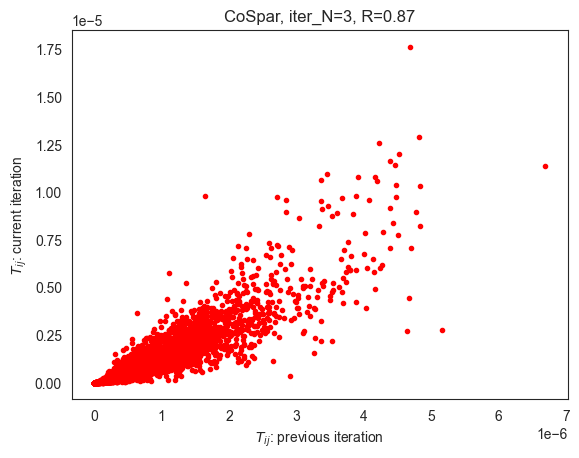

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  6.9894022941589355
--> Phase II: time elapsed --  9.038403749465942
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--> Clone id: 1000
--------Current initial time point: 2--------
Step 1: Select time points
--> Clonal cell fraction (day 2-3): 0.6362100181050091
--> Clonal cell fraction (day 3-2): 0.6094479436828455
--> Numer of cells that are clonally related -- day 2: 5271  and day 3: 16449
Number of multi-time clones post selection: 781
Cell number=35275, Clone number=781
--> clonal_cell_id_t1: 5271
--> Tmap_cell_id_t1: 8285
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
--> Load from hard disk--------
--> Compute similarity matrix: load existing data
--> Time elapsed:  0.49036192893981934
--> Time elapsed:  5.058647394180298
--> Time elapsed:  0.74856805801391

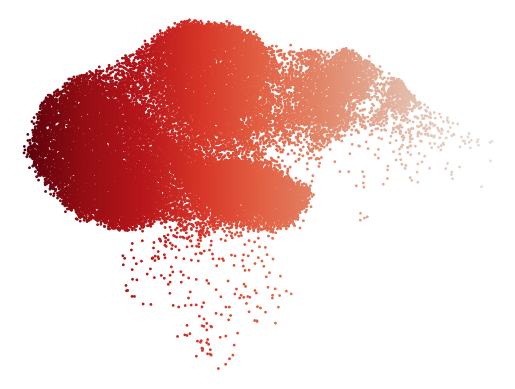

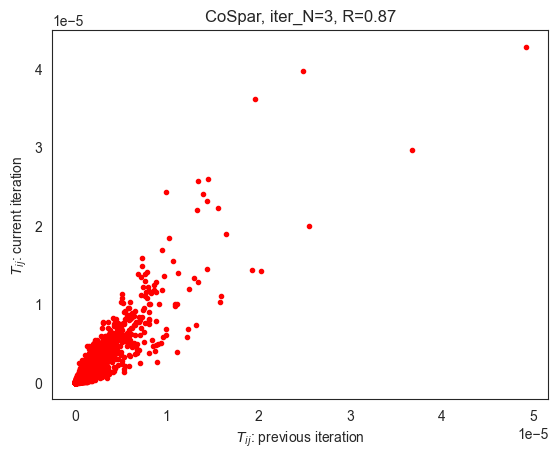

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  7.16227126121521
--> Phase II: time elapsed --  8.2032310962677
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
-----------Total used time: 6466.836066484451 s ------------
Results saved at adata.obs['fate_map_transition_map_14_low']
Results saved at adata.obs['fate_map_transition_map_14_high']
Results saved at adata.obs['fate_bias_transition_map_14_low*14_high']
(56419, 10269)
(56419, 5134)
Time points with clonal info: [0 1 2 3]
------Compute the full Similarity matrix if necessary------
--> Compute similarity matrix: computing new; beta=0.1
Smooth round: 1
--> Time elapsed: 0.7001645565032959
Smooth round: 2
--> Time elapsed: 1.3440611362457275
Smooth round: 3
--> Time elapsed: 15.312949180603027
--> Orignal sparsity=0.10522440271933081, Thresholding
--> Final sparsity=0.052967936722433266
similar

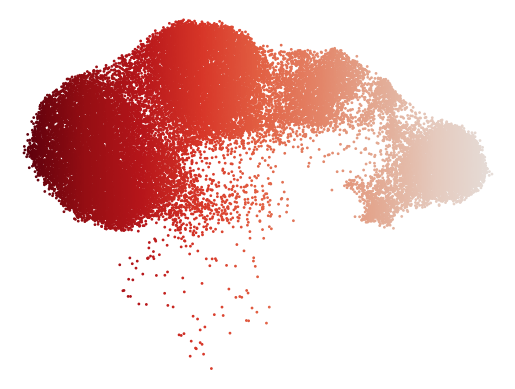

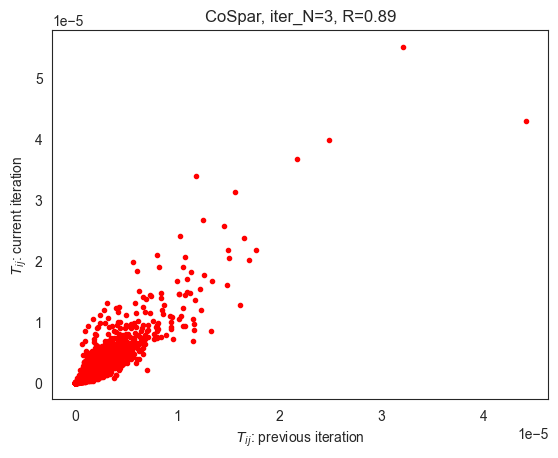

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  4.285613775253296
--> Phase II: time elapsed --  4.84279465675354
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--------Current initial time point: 1--------
Step 1: Select time points
--> Clonal cell fraction (day 1-3): 0.4663789502993178
--> Clonal cell fraction (day 3-1): 0.631233790292701
--> Numer of cells that are clonally related -- day 1: 6700  and day 3: 17037
Number of multi-time clones post selection: 1108
Cell number=41356, Clone number=1108
--> clonal_cell_id_t1: 6700
--> Tmap_cell_id_t1: 14366
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
--> Load from hard disk--------
--> Compute similarity matrix: load existing data
--> Time elapsed:  0.7465400695800781
--> Time elapsed:  5.887019157409668
--> Time elapsed:  1.537250280380249
--> Time elapsed: 

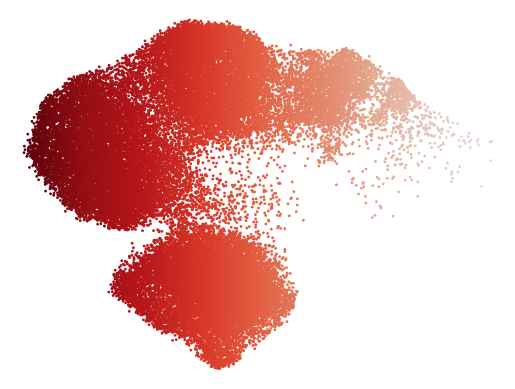

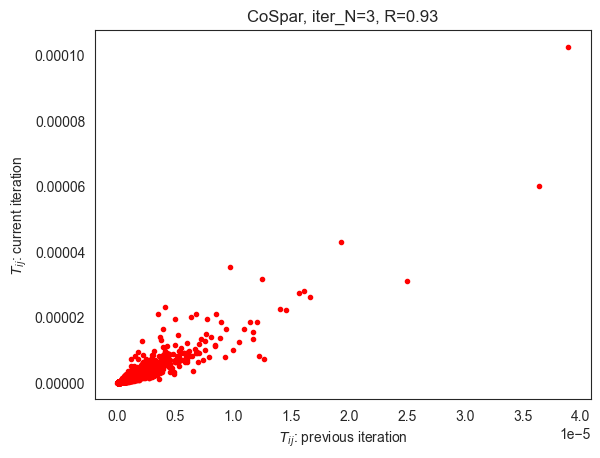

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  5.4783244132995605
--> Phase II: time elapsed --  7.676083326339722
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--> Clone id: 1000
--------Current initial time point: 2--------
Step 1: Select time points
--> Clonal cell fraction (day 2-3): 0.632106216053108
--> Clonal cell fraction (day 3-2): 0.6026676546869211
--> Numer of cells that are clonally related -- day 2: 5237  and day 3: 16266
Number of multi-time clones post selection: 792
Cell number=35275, Clone number=792
--> clonal_cell_id_t1: 5237
--> Tmap_cell_id_t1: 8285
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
--> Load from hard disk--------
--> Compute similarity matrix: load existing data
--> Time elapsed:  0.4817385673522949
--> Time elapsed:  5.006281614303589
--> Time elapsed:  0.7649147510528564

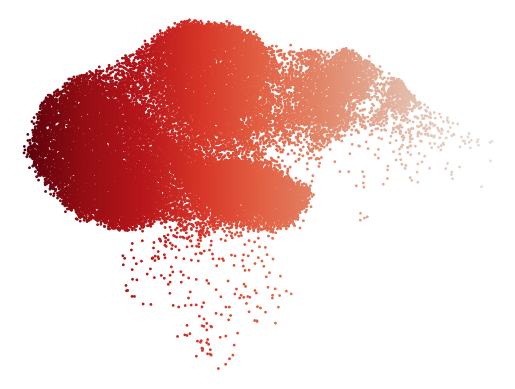

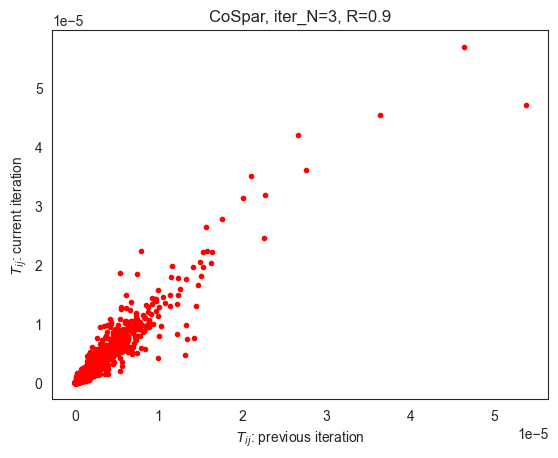

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  7.46187424659729
--> Phase II: time elapsed --  8.461981534957886
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
-----------Total used time: 6432.133381843567 s ------------
Results saved at adata.obs['fate_map_transition_map_14_low']
Results saved at adata.obs['fate_map_transition_map_14_high']
Results saved at adata.obs['fate_bias_transition_map_14_low*14_high']
(56419, 10269)
(56419, 5134)
Time points with clonal info: [0 1 2 3]
------Compute the full Similarity matrix if necessary------
--> Compute similarity matrix: computing new; beta=0.1
Smooth round: 1
--> Time elapsed: 0.7116031646728516
Smooth round: 2
--> Time elapsed: 1.3498761653900146
Smooth round: 3
--> Time elapsed: 15.223360538482666
--> Orignal sparsity=0.10522440271933081, Thresholding
--> Final sparsity=0.052967936722433266
simil

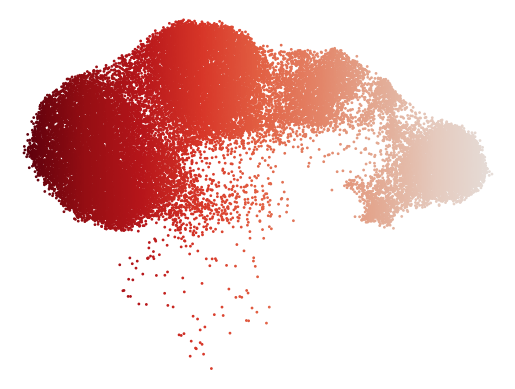

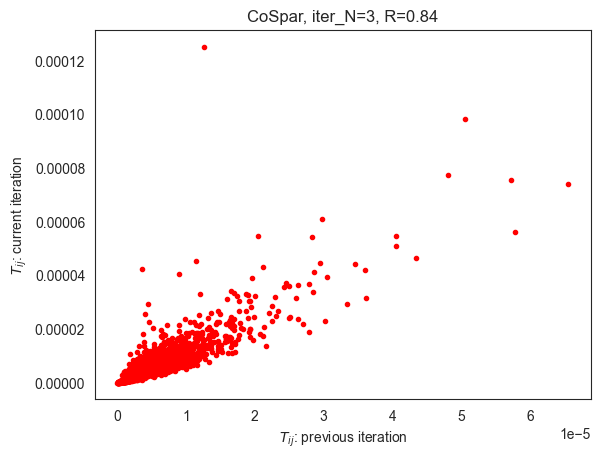

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.41864442825317383
--> Phase II: time elapsed --  0.7677488327026367
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--------Current initial time point: 1--------
Step 1: Select time points
--> Clonal cell fraction (day 1-3): 0.25971042739802314
--> Clonal cell fraction (day 3-1): 0.18177102630603928
--> Numer of cells that are clonally related -- day 1: 3731  and day 3: 4906
Number of multi-time clones post selection: 1084
Cell number=41356, Clone number=1084
--> clonal_cell_id_t1: 3731
--> Tmap_cell_id_t1: 14366
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
--> Load from hard disk--------
--> Compute similarity matrix: load existing data
--> Time elapsed:  0.3456859588623047
--> Time elapsed:  2.781931161880493
--> Time elapsed:  1.2847542762756348
--> Time el

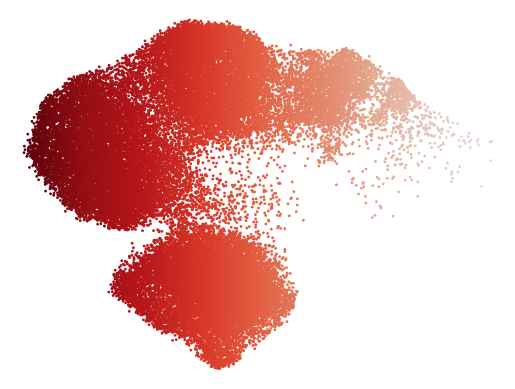

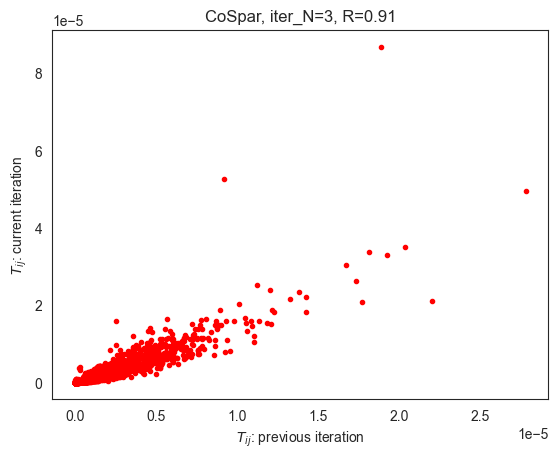

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.7270357608795166
--> Phase II: time elapsed --  2.047776699066162
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--> Clone id: 1000
--------Current initial time point: 2--------
Step 1: Select time points
--> Clonal cell fraction (day 2-3): 0.1939649969824985
--> Clonal cell fraction (day 3-2): 0.1550574286772879
--> Numer of cells that are clonally related -- day 2: 1607  and day 3: 4185
Number of multi-time clones post selection: 767
Cell number=35275, Clone number=767
--> clonal_cell_id_t1: 1607
--> Tmap_cell_id_t1: 8285
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
--> Load from hard disk--------
--> Compute similarity matrix: load existing data
--> Time elapsed:  0.11524629592895508
--> Time elapsed:  2.0876526832580566
--> Time elapsed:  0.56373691558837

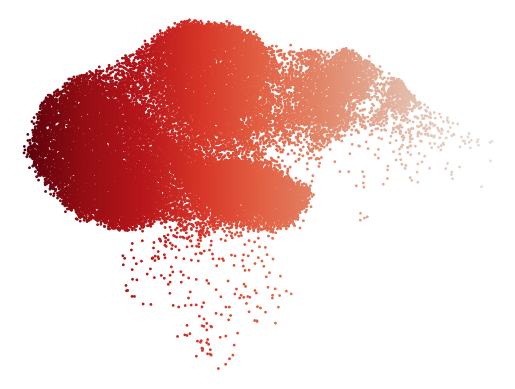

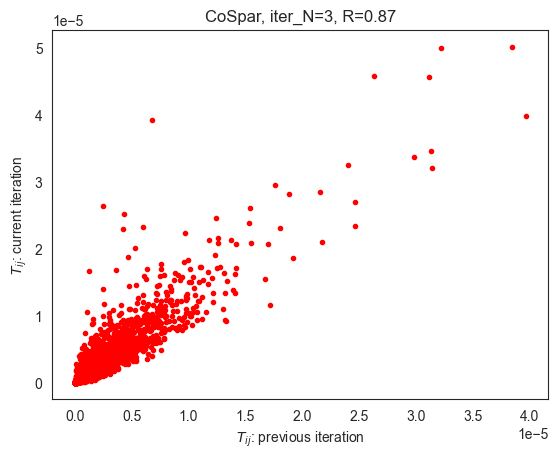

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.4958500862121582
--> Phase II: time elapsed --  0.957573652267456
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
-----------Total used time: 5592.159117698669 s ------------
Results saved at adata.obs['fate_map_transition_map_14_low']
Results saved at adata.obs['fate_map_transition_map_14_high']
Results saved at adata.obs['fate_bias_transition_map_14_low*14_high']
(56419, 10269)
(56419, 5134)
Time points with clonal info: [0 1 2 3]
------Compute the full Similarity matrix if necessary------
--> Compute similarity matrix: computing new; beta=0.1
Smooth round: 1
--> Time elapsed: 0.7015590667724609
Smooth round: 2
--> Time elapsed: 1.3289079666137695
Smooth round: 3
--> Time elapsed: 15.23625659942627
--> Orignal sparsity=0.10522440271933081, Thresholding
--> Final sparsity=0.052967936722433266
simi

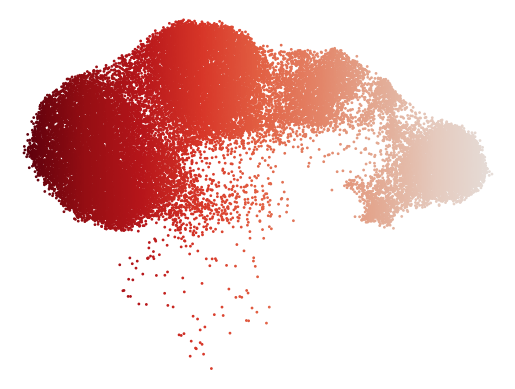

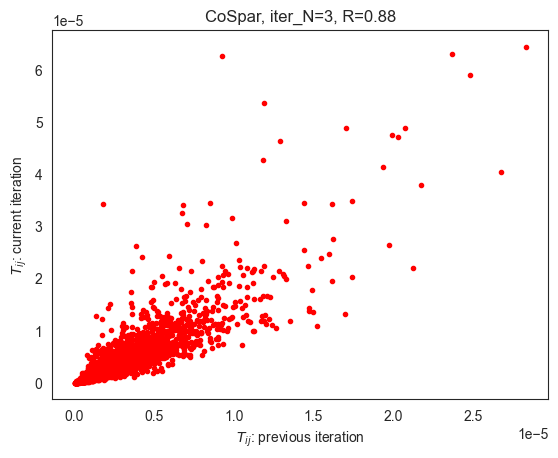

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.43578481674194336
--> Phase II: time elapsed --  0.8125312328338623
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--------Current initial time point: 1--------
Step 1: Select time points
--> Clonal cell fraction (day 1-3): 0.259153557009606
--> Clonal cell fraction (day 3-1): 0.19110781771026306
--> Numer of cells that are clonally related -- day 1: 3723  and day 3: 5158
Number of multi-time clones post selection: 1097
Cell number=41356, Clone number=1097
--> clonal_cell_id_t1: 3723
--> Tmap_cell_id_t1: 14366
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
--> Load from hard disk--------
--> Compute similarity matrix: load existing data
--> Time elapsed:  0.3457221984863281
--> Time elapsed:  2.858668088912964
--> Time elapsed:  1.2846643924713135
--> Time elap

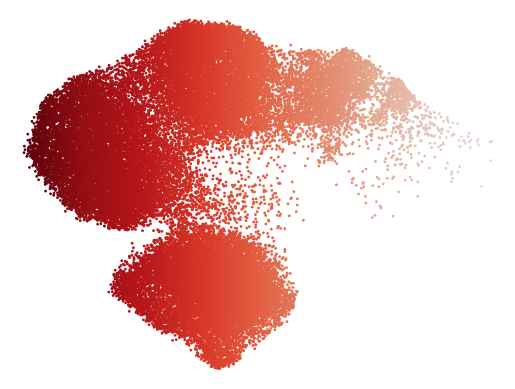

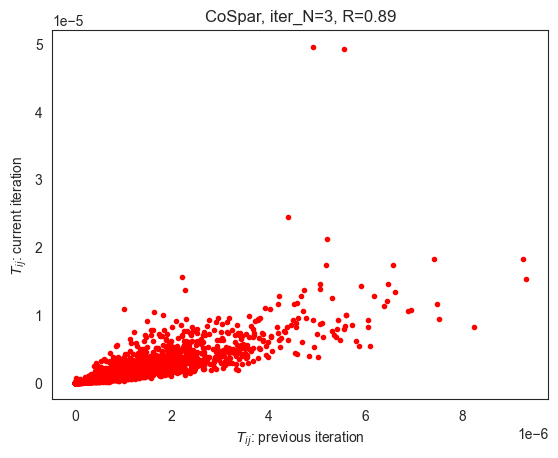

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.6282503604888916
--> Phase II: time elapsed --  2.0572478771209717
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--> Clone id: 1000
--------Current initial time point: 2--------
Step 1: Select time points
--> Clonal cell fraction (day 2-3): 0.18780929390464696
--> Clonal cell fraction (day 3-2): 0.17084105224157095
--> Numer of cells that are clonally related -- day 2: 1556  and day 3: 4611
Number of multi-time clones post selection: 775
Cell number=35275, Clone number=775
--> clonal_cell_id_t1: 1556
--> Tmap_cell_id_t1: 8285
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
--> Load from hard disk--------
--> Compute similarity matrix: load existing data
--> Time elapsed:  0.11142158508300781
--> Time elapsed:  2.1211140155792236
--> Time elapsed:  0.56956529617

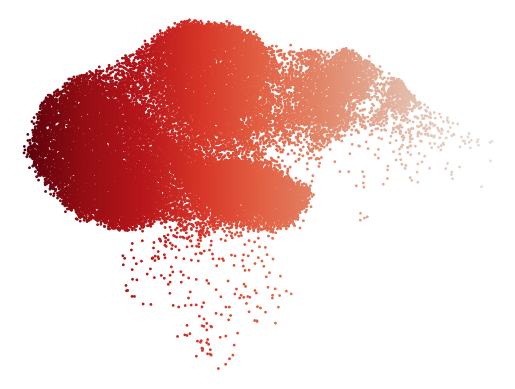

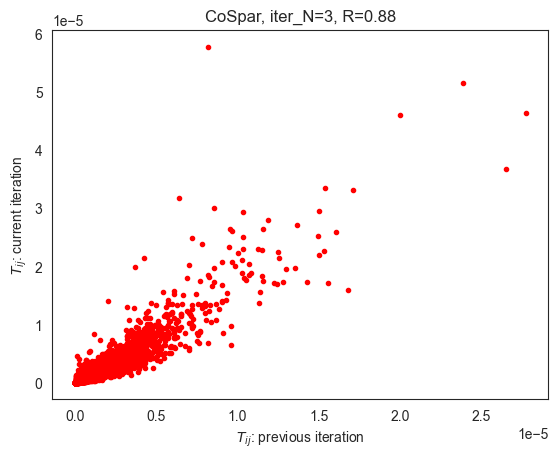

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.5316109657287598
--> Phase II: time elapsed --  0.9947640895843506
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
-----------Total used time: 5565.0494158267975 s ------------
Results saved at adata.obs['fate_map_transition_map_14_low']
Results saved at adata.obs['fate_map_transition_map_14_high']
Results saved at adata.obs['fate_bias_transition_map_14_low*14_high']


In [52]:
for e in range(10):
    adata_orig = adata.copy()
    generate_clone_matrix(adata_orig, 'lineage_barcode')
    print(adata_orig.obsm['X_clone'].shape)
    selected_clone = np.random.choice(range(adata_orig.obsm['X_clone'].shape[1]), size=int(0.5 * adata_orig.obsm['X_clone'].shape[1]), replace=False)
    adata_orig.obsm['X_clone'] = adata_orig.obsm['X_clone'][:,selected_clone]
    print(adata_orig.obsm['X_clone'].shape)
    adata_orig = cs.pp.initialize_adata_object(adata_orig)
    
    adata_lineage = cs.tmap.infer_Tmap_from_multitime_clones(
            adata_orig,
            clonal_time_points=[ 0,1,2, 3],
            later_time_point=3,
            smooth_array=[ 15, 10, 5],
            sparsity_threshold=0.2,
            intraclone_threshold=0.2,
            max_iter_N=3,
            compute_new=True
    )
    cs.tl.fate_bias(
        adata_lineage,
        selected_fates=["14_low", "14_high"],
        source="transition_map",
        map_backward=True,
        method="norm-sum",
    )
       
    adata_lineage.obs.to_csv('../pygot_data/03_cellfate/Oren/cospar_{}.csv'.format(e))

In [27]:
cospar_dfs = []
for e in range(10):
    cospar_dfs.append(pd.read_csv('../pygot_data/03_cellfate/Oren/cospar_{}.csv'.format(e),index_col=0))

## Cell fate computation

In [13]:
got_dfs = []
for got in gots:
    adata.obsm[velocity_key] = pygot.tl.traj.latent_velocity(adata, got, embedding_key=embedding_key, time_key=time_key)
    cellfate = pygot.tl.analysis.CellFate()
    cellfate.fit(adata, embedding_key=embedding_key, velocity_key=velocity_key, cell_type_key=cell_type_key,
                 sde=True, D=1.,
                  target_cell_types=['14_low', '14_high'], mutual=False)
    adata.obs['got_fate_bias'] = hf.get_fate_bias(adata.obsm['descendant'],['14_low', '14_high'] )
    got_dfs.append(adata.obs.copy())

2025-03-27 22:33:45 	 Compute transition roadmap among [0 1]
2025-03-27 22:33:45 	 Compute transition between 0 and 1
2025-03-27 22:33:47 	 Compute velocity graph
Scale factor: 5.2752633
Scale factor: 5.2752633
2025-03-27 22:34:45 	 Convert into markov chain
2025-03-27 22:34:45 	 Solve abosorbing probabilities
2025-03-27 22:34:46 	 Generate NULL distribution
Export result into adata.obsm['descendant'] and adata.obsm['ancestor']
2025-03-27 22:34:46 	 Compute transition roadmap among [0 1]
2025-03-27 22:34:46 	 Compute transition between 0 and 1
2025-03-27 22:34:49 	 Compute velocity graph
Scale factor: 5.329376
Scale factor: 5.329376
2025-03-27 22:35:20 	 Convert into markov chain
2025-03-27 22:35:21 	 Solve abosorbing probabilities
2025-03-27 22:35:21 	 Generate NULL distribution
Export result into adata.obsm['descendant'] and adata.obsm['ancestor']
2025-03-27 22:35:22 	 Compute transition roadmap among [0 1]
2025-03-27 22:35:22 	 Compute transition between 0 and 1
2025-03-27 22:35:25 

In [24]:
pred_bias_gots = [df.loc[x0_adata.obs.index]['got_fate_bias'].to_numpy() for df in got_dfs]
gots_res = [hf.correlation_2x2(pred_bias_gots[i], x0_adata, fate_bias_key=groundtruth_key, embedding_key=embedding_key).to_numpy() for i in range(len(pred_bias_gots))]
np.array(gots_res)[:,1,0]

array([0.35013497, 0.34810794, 0.33766841, 0.34267915, 0.36119431,
       0.36806906, 0.3550321 , 0.35317507, 0.35175476, 0.34281404])

In [29]:
#GOT
pred_bias_gots = [df.loc[x0_adata.obs.index]['got_fate_bias'].to_numpy() for df in got_dfs]


#WOT
pred_bias_wot = [df.loc[x0_adata.obs.index].apply(lambda x: x['14_low'] / (x['14_low'] + x['14_high']), axis=1 ).to_numpy() for df in wot_dfs] 


#MOSCOT
pred_bias_moscot = [df.loc[x0_adata.obs.index]['moscot_fate_bias'].apply(lambda x: .5 if np.isnan(x) else x).to_numpy() for df in moscot_dfs]

#Cospar
pred_bias_cospars = [df.loc[x0_adata.obs.index]['fate_bias_transition_map_14_low*14_high'].to_numpy() for df in cospar_dfs]
#    pred_bias_cospars.append(pd.read_csv('./benchmark_model/Cospar/03_cell_fate/reprogramming_fate/cospar_{}.csv'.format(i), index_col=0).loc[x0_adata.obs.index.to_series().astype(int)]['fate_bias_transition_map_Reprogrammed*Failed'].to_numpy())



## Benchmark

In [30]:
wot_res = [hf.correlation_2x2(pred_bias_wot[i],  x0_adata, fate_bias_key=groundtruth_key, embedding_key=embedding_key).to_numpy() for i in range(len(pred_bias_wot))]
moscot_res = [hf.correlation_2x2(pred_bias_moscot[i],  x0_adata, fate_bias_key=groundtruth_key, embedding_key=embedding_key).to_numpy() for i in range(len(pred_bias_moscot))]
gots_res = [hf.correlation_2x2(pred_bias_gots[i], x0_adata, fate_bias_key=groundtruth_key, embedding_key=embedding_key).to_numpy() for i in range(len(pred_bias_gots))]
cospar_res = [hf.correlation_2x2(pred_bias_cospars[i], x0_adata, fate_bias_key=groundtruth_key, embedding_key=embedding_key).to_numpy() for i in range(len(pred_bias_cospars))]

In [31]:
pcc_df =  pd.DataFrame([np.concatenate([
            np.array(gots_res)[:,1,0],
            np.array(moscot_res)[:,1,0],
            np.array(cospar_res)[:,1,0],
            np.array(wot_res)[:,1,0],
            
            ]), ['GOT']*len(gots_res)  + ["Moscot"]*len(moscot_res) + ["Cospar\n(with clone)"]*len(cospar_res) + ['WOT']*len(wot_res)  
                       ], index=['PCC', 'Method']).T


In [42]:
pcc_df.to_csv('./results/03_cellfate/cancer_res.csv')

In [17]:
pcc_df = pd.read_csv('./results/03_cellfate/cancer_res.csv')

In [16]:
import mplscience
mplscience.set_style(reset_current=True)
plt.rcParams['font.sans-serif'] = ['Arial']
pal=sns.color_palette()
paln=pal.copy()
paln[0]=np.array([13,111,178])/255

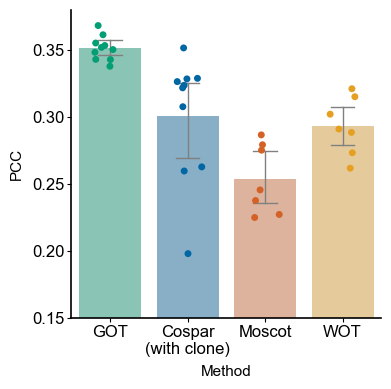

In [45]:
# 假设 plot_result 是您的 DataFrame

palette = {
    'GOT':'#049e74',
    'Cospar\n(with clone)':'#0066a4',
    'Moscot': '#d46126',
    'WOT':'#e5a023',
}
#palette = 'Accent'
# 先画条形图
ax = sns.barplot(
    x='Method', y='PCC', data=pcc_df.loc[pcc_df['Method'].isin(['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT'])], 
    
    capsize=.3,
    err_kws={"linewidth": 1., 'color':'grey'},
    palette=palette,
    order=['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT'],
    #fill=False,
    legend=False,
    alpha=0.5
    
)

# 再叠加抖动点图
sns.stripplot(
    x='Method', y='PCC', data=pcc_df.loc[pcc_df['Method'].isin(['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT'])], 
    
    dodge=False,  # 分开展示不同方法
    jitter=0.2,  # 控制抖动幅度
    palette=palette, 
    alpha=1.,
    legend=False,
    #ax=ax,
    size=5,
    order=['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT']
)
plt.ylim(0.15, 0.38)
plt.show()

SCC: 0.3309011550809994
PCC: 0.4152088390756353
Mean Squared Error: 0.11793959753296815
R-squared: 0.17079911631567313
ROC-AUC: 0.7176764141445919


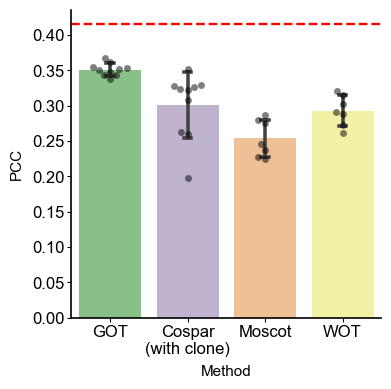

In [37]:
scc, pcc, mse, r2, auc = hf.positive_control(x0_adata, embedding_key, groundtruth_key)
pcc_df = pd.concat([pcc_df, pd.DataFrame([pcc, 'supervised LR'], index=['PCC', 'Method']).T])
sns.barplot(x='Method', y='PCC', data=pcc_df.loc[pcc_df['Method'].isin(['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT'])], 
            capsize=.1, ci="sd", order=['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT'], 
            palette='Accent')  
sns.swarmplot(x='Method', y='PCC', data=pcc_df.loc[pcc_df['Method'].isin(['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT'])], 
              color="black", alpha=.5, order=['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT']) 

plt.axhline(y=pcc_df.loc[pcc_df['Method'] == 'supervised LR']['PCC'].tolist()[0], color='red', linestyle='--', label='supervised linear regression')
plt.show()
plt.close()

In [38]:
pcc_df.groupby('Method').apply(lambda x: x.PCC.mean())

Method
Cospar\n(with clone)    0.300664
GOT                     0.351063
Moscot                  0.253568
WOT                     0.293052
supervised LR           0.415209
dtype: float64

In [39]:
show_idx = x0_adata.obs.index

basis='draw_graph_fa'

In [41]:
import matplotlib.colors as mcolors

#colors = ["blue", "white", "red"]
#custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors)
custom_cmap='coolwarm'

norm = mcolors.TwoSlopeNorm(vmin=0., vcenter=0.5, vmax=1.)
fig, axes = plt.subplots(1, 5, figsize=(6.4*4, 4.8))

sc.pl.embedding(x0_adata[show_idx], color=groundtruth_key, ax=axes[0], basis=basis, cmap='coolwarm', colorbar_loc=None, frameon=False, title='', show=False)

print(hf.correlation_2x2(pred_bias_gots[np.array(gots_res)[:,1,0].argsort()[len(gots_res) // 2]], x0_adata, groundtruth_key, embedding_key))
sc.pl.embedding(x0_adata[show_idx], color='pred_fate_bias', ax=axes[1], basis=basis, cmap=custom_cmap, norm=norm, colorbar_loc=None, frameon=False, title='', show=False)

print(hf.correlation_2x2(pred_bias_cospars[np.array(cospar_res)[:,1,0].argsort()[len(cospar_res) // 2]], x0_adata, groundtruth_key, embedding_key))
sc.pl.embedding(x0_adata[show_idx], color='pred_fate_bias', ax=axes[2], basis=basis, cmap=custom_cmap, norm=norm, colorbar_loc=None, frameon=False, title='', show=False)

print(hf.correlation_2x2(pred_bias_moscot[np.array(moscot_res)[:,1,0].argsort()[len(moscot_res) // 2]], x0_adata, groundtruth_key, embedding_key))
sc.pl.embedding(x0_adata[show_idx], color='pred_fate_bias', ax=axes[3], basis=basis, cmap=custom_cmap, norm=norm, colorbar_loc=None, frameon=False, title='', show=False)

print(hf.correlation_2x2(pred_bias_wot[np.array(wot_res)[:,1,0].argsort()[len(wot_res) // 2]], x0_adata, groundtruth_key, embedding_key))
sc.pl.embedding(x0_adata[show_idx], color='pred_fate_bias', ax=axes[4], basis=basis, cmap=custom_cmap, norm=norm, colorbar_loc=None, frameon=False, title='', show=False)
#plt.show()



     pred vs gt  sm pred vs gt  pred vs sm gt  sm pred vs sm gt
scc    0.266007       0.246090       0.316927          0.310563
pcc    0.351755       0.323394       0.484296          0.486743
mse    0.137516       0.134672       0.052428          0.042111
r2    -1.977199      -3.566436      -0.135060         -0.427907
auc    0.668969       0.655122       0.821389          0.820377
     pred vs gt  sm pred vs gt  pred vs sm gt  sm pred vs sm gt
scc    0.257503       0.246412       0.333207          0.347161
pcc    0.323437       0.288687       0.470331          0.455065
mse    0.185782       0.184546       0.098044          0.092778
r2    -8.584777     -12.500085      -4.058242         -5.787021
auc    0.664218       0.658574       0.820136          0.822624
     pred vs gt  sm pred vs gt  pred vs sm gt  sm pred vs sm gt
scc    0.254960       0.238513       0.295750          0.296781
pcc    0.245338       0.262548       0.323581          0.374546
mse    0.293371       0.218642       0.2

In [83]:
ent(pred_bias_moscot[-4])

0.2184553631376289

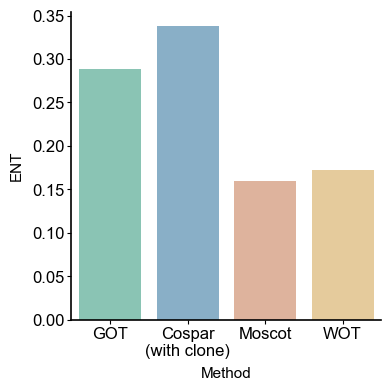

In [86]:
def ent(x):
    return -np.sum(np.log(x[(x>0.05)&(x<0.95)])*x[(x>0.05)&(x<0.95)]) / len(x)
    
ent_df =  pd.DataFrame([np.concatenate([
            [ent(x) for x in pred_bias_gots],
            [ent(x) for x in pred_bias_moscot],
            [ent(x) for x in pred_bias_cospars],
            [ent(x) for x in pred_bias_wot],
            
            ]), ['GOT']*len(gots_res)  + ["Moscot"]*len(moscot_res) + ["Cospar\n(with clone)"]*len(cospar_res) + ['WOT']*len(wot_res)  
                       # + ['OT-CFM']*len(wot_res) + ['MIOFlow']*len(mioflows_res) 
                       ], index=['ENT', 'Method']).T


palette = {
    'GOT':'#049e74',
    'Cospar\n(with clone)':'#0066a4',
    'Moscot': '#d46126',
    'WOT':'#e5a023',
}


ax = sns.barplot(
    x='Method', y='ENT', data=ent_df.loc[ent_df['Method'].isin(['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT'])], 
    
    capsize=.3,
    errorbar=None,
    err_kws={"linewidth": 1., 'color':'grey'},
    palette=palette,
    order=['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT'],
    #fill=False,
    legend=False,
    alpha=0.5
    
)




plt.show()

In [87]:
ent_df.to_csv('./results/03_cellfate/cancer_ent.csv')